In [9]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

In [2]:
# get_pattern_inds.m

def get_pattern_inds(pattern):
  """
  This is a helper function that determines where all of the boundaries of
  the light pattern are located. These are returned as indices FROM and
  indices TO, representing the directions of flux.

  Inputs
  pattern - a binary mask of the light input

  Outputs (tuple with values:)
  idf - flux downward FROM these indices
  idt - flux downward TO these indices
  iuf - flux upward FROM these indices
  iut - flux upward TO these indices
  ilf - flux leftward FROM these indices
  ilt - flux leftward TO these indices
  irf - flux rightward FROM these indices
  irt - flux rightward TO these indices
  """

  # find 2D boundaries with flux left, right, up, down
  conv_down = convolve2d(pattern, np.array([[1], [0], [-1]]), mode='same')
  conv_up = convolve2d(pattern, np.array([[1], [0], [-1]]), mode='same')
  conv_right = convolve2d(pattern, np.array([[1, 0, -1]]), mode='same')
  conv_left = convolve2d(pattern, np.array([[1, 0, -1]]), mode='same')

  # find indices where rising & falling edges occur
  inds_down = np.where(conv_down > 0)
  inds_up = np.where(conv_up < 0)
  inds_right = np.where(conv_right > 0)
  inds_left = np.where(conv_left < 0)

  #size of pattern
  sz = pattern.shape

  # i_ = row indices, j_ = column indices

  id, jd = inds_down
  iu, ju = inds_up
  ir, jr = inds_right
  il, jl = inds_left


  """
  id, jd = np.unravel_index(inds_down, sz)
  iu, ju = np.unravel_index(inds_up, sz)
  ir, jr = np.unravel_index(inds_right, sz)
  il, jl = np.unravel_index(inds_left, sz)
  """

  """
  # neighboring indices where flux is coming from (sub2ind equivalent)
  idt = inds_down #np.ravel_multi_index((id, jd), sz)
  idf = np.ravel_multi_index((id-1, jd), sz)

  iut = inds_up #np.ravel_multi_index((iu, ju), sz)
  iuf = np.ravel_multi_index((iu+1, ju), sz)

  ilt = inds_left #np.ravel_multi_index((il, jl), sz)
  ilf = np.ravel_multi_index((il, jl+1), sz)

  irt = inds_right #np.ravel_multi_index((ir, jr), sz)
  irf = np.ravel_multi_index((ir, jr-1), sz)
  """

  # neighboring indices where flux is coming from (sub2ind equivalent)
  #The following lines are modified to ensure indices are within bounds
  idt = (id, jd)  # Store as 2D indices instead of linear indices
  idf = (np.clip(id-1, 0, sz[0]-1), jd)  # Clip id-1 to be within bounds

  iut = (iu, ju)  # Store as 2D indices instead of linear indices
  iuf = (np.clip(iu+1, 0, sz[0]-1), ju)  # Clip iu+1 to be within bounds

  ilt = (il, jl) # Store as 2D indices instead of linear indices
  ilf = (il, np.clip(jl+1, 0, sz[1]-1)) # Clip jl+1 to be within bounds

  irt = (ir, jr) # Store as 2D indices instead of linear indices
  irf = (ir, np.clip(jr-1, 0, sz[1]-1)) # Clip jr-1 to be within bounds


  return idf, idt, iuf, iut, ilf, ilt, irf, irt


In [3]:
def construct_2D_model(N, L, pattern):
  """
  This function builds a differential equation model of a 2D layer of
  cells that expands by diffusion and also experiences a flux at boundaries
  of a light pattern.

  Input arguments:
  N - the number of compartments to discretize each dimension
  L - the length and width of the square of cells
  pattern - the illumination pattern driving localized cell movement

  Output
  model_fcn - a function handle to an ODE system that can be run using
              an ODE solver like ode15s().
              ==> using solve_ivp from scipy.integrate instead
  """

  # Get size of each box for scaling diffusion/flux in the rate equations
  dxy = L / N  # size of each compartment

  # Diffusion parameters
  D = 50  # units: um^2/min

  # Parameter associated with flux:
  f = 0.3  # units: (min^-1)

  """
  This is a set of coordinates representing every compartment in the 2D
  field of cells. For every index in "center", the index in "right" is the
  compartment to its right, "left" is the compartment to its left, etc.

  Assume matrix positions:
  y(center,1) = first COLUMN
  y(1,center) = first ROW
  """
  center = np.arange(N) # simulating N compartments

  right = np.roll(center, -1)   # position 2 is RIGHT compared to 1
  left = np.roll(center, 1)     # position 1 is LEFT compared to 2
  down = np.roll(center, -1)    # position 2 is DOWN compared to 1
  up = np.roll(center, 1)       # 1 is UP compared to 2

  # If there is no light pattern, initialize with a pattern of zeros.
  if (pattern is None) or (pattern.size == 0):
    pattern = np.zeros((N, N))

  # Get pattern indices
  idf, idt, iuf, iut, ilf, ilt, irf, irt = get_pattern_inds(pattern)


  def model_fcn(t, y):  # return function handle to model

    # THIS IS THE ODE SYSTEM RETURNED BY CONSTRUCT_2D_MODEL

    # reshape the ODE system to a square pattern of cells!
    y = np.reshape(y, (N, N))

    # Initialize dydt with zeros
    dydt = np.zeros((N, N))

    # Assume matrix positions:
    # y(center,1) = first COLUMN
    # y(1,center) = first ROW
    # diffusion terms:

    # This equation defines diffusion within the 2D geometry
    # dydt[center, center] = (y[left, center] + y[right, center] +    # IN from left & right
                            #y[center, up] + y[center, down] -       # IN from up & down
                            #4*y[center, center]);                   # OUT from center
    dydt[:, :] = (y[left, :] + y[right, :] +    # IN from left & right
                            y[:, up] + y[:, down] -       # IN from up & down
                            4*y[:, :]);                   # OUT from center

    # These equations define diffusion at the edges
    dydt[0, center] = y[1, center] + y[0, right] + y[0, left] - 3*y[0, center]
    dydt[-1, center] = y[-2, center] + y[-1, right] + y[-1, left] - 3*y[-1, center]
    dydt[center, 0] = y[up, 0] + y[down, 0] + y[center, 1] - 3*y[center, 0]
    dydt[center, -1] = y[up, -1] + y[down, -1] + y[center, -2] - 3*y[center, -1]

    # these equations define diffusion at corner squares
    dydt[0, 0]    = y[0, 1] + y[1, 0] - 2*y[0, 0]
    dydt[-1, -1]  = y[-1, -2] + y[-2, -1] - 2*y[-1, -1]
    dydt[0, -1]   = y[0, -2] + y[1, -1] - 2*y[0, -1]
    dydt[-1, 0]   = y[-2, 0] + y[-1, 1] - 2*y[-1, 0]

    # All diffusion terms must be scaled by the box size "dxy" as below
    dydt = D/dxy**2*dydt

    # Now we further add cell movement based on light boundary fluxes.
    # Flux upwards:
    dydt[iuf] -= f/dxy*y[iuf]  # flux up FROM indices
    dydt[iut] += f/dxy*y[iuf]  # flux up TO indices
    # Flux downwards:
    dydt[idf] -= f/dxy*y[idf]  # flux down FROM indices
    dydt[idt] += f/dxy*y[idf]  # flux down TO indices
    # Flux leftwards:
    dydt[ilf] -= f/dxy*y[ilf]  # flux left FROM indices
    dydt[ilt] += f/dxy*y[ilf]  # flux left TO indices
    # Flux rightwards:
    dydt[irf] -= f/dxy*y[irf]  # flux right FROM indices
    dydt[irt] += f/dxy*y[irf]  # flux right TO indices

    dydt = np.reshape(dydt, N**2)

    return dydt

  return model_fcn

In [4]:
from google.colab import files
uploaded = files.upload() # to upload illuminati_pattern.mat file with pattern data

Saving illuminati_pattern.mat to illuminati_pattern.mat


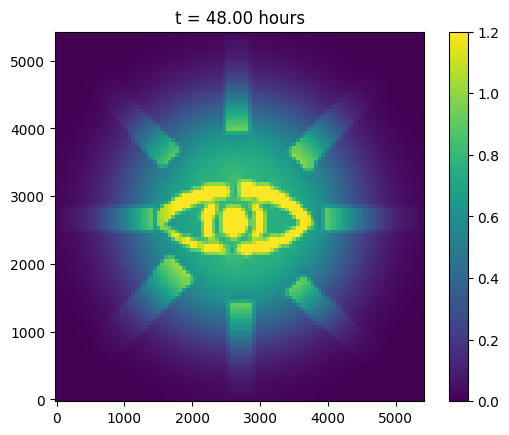

In [5]:
# Generating Figure 6
from scipy.io import loadmat, savemat
from scipy.interpolate import interp1d
import time

# PART 1: SIMULATE THE PATTERN

# load the illuminati pattern
data = loadmat('illuminati_pattern.mat')
pattern = data['pattern']

# this is just some simple manipulations to make sure the pattern is
# well-behaved (e.g., it is binary, and the boundaries are dark).
pattern = np.flipud(pattern)
pattern[:, 0:2] = 0
pattern[:, -2:] = 0
pattern[0:2, :] = 0
pattern[-2:, :] = 0
pattern = pattern > 0

# Simulate the expanding tissue under illumination
N = 101
L = 5400  # simulation width in um (5.4 mm = 5,400 um)
tF = 2880  # simulation time in min (48 h = 2,880 min)

f = construct_2D_model(N, L, pattern)

#ic = np.zeros((N, N)) # WHAT ARE THE INITIAL CONDITIONS?
#ic = np.random.poisson(3, size=(N, N))
ic = data['ic']
ic = np.reshape(ic, (N**2,))

tic = time.time()
solution = solve_ivp(f, [0, tF], ic)
toc = time.time()

tv = np.linspace(0, tF, 290)
yv = interp1d(solution.t, solution.y)(tv)

savemat('Fig6_simulation_results.mat', {'L': L, 'N': N, 'tF': tF, 'tv': tv, 'yv': solution.y.T})

# PART 2: Plot the results!
result = loadmat('Fig6_simulation_results.mat')

xv = np.linspace(0, L, N)
X, Y = np.meshgrid(xv, xv)

# Plotting just the last timestep
index = -1
Z = np.reshape(yv[:, index], (N, N))
plt.pcolor(X, Y, Z, edgecolors='none')
plt.title(f't = {tv[index] / 60:.2f} hours')  # Convert time to hours
plt.clim(0, 1.2)
plt.axis('square')
plt.colorbar()
plt.show()

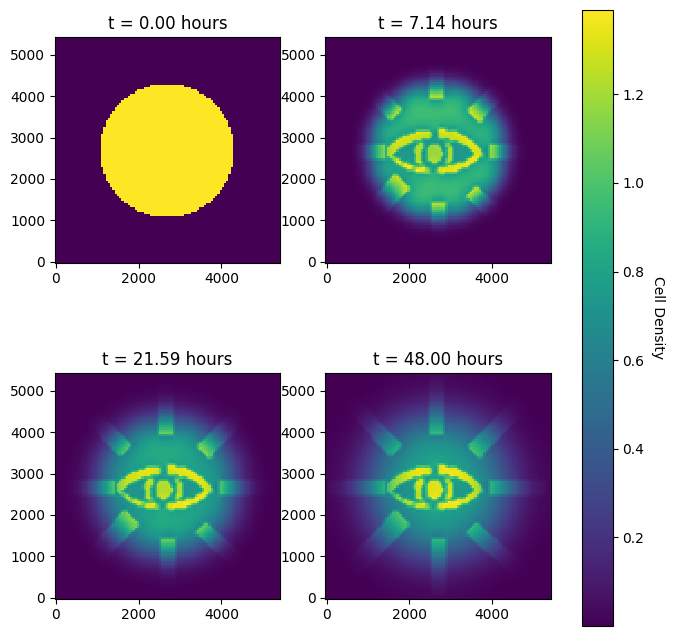

In [6]:
# Plot fo JP


time_points = [0, 0.15, 0.45, 1] # time breaks out

fig, axes = plt.subplots(2, 2, figsize=(8, 8)) # backdrop for 2x2 figure

for i, time in enumerate(time_points):
    index = np.argmin(np.abs(tv - time * tF)) # get whole number of timepoint

    # Reshape the cell density data for plotting
    Z = np.reshape(yv[:, index], (N, N))  # Assuming N is the grid size

    # subplot position
    row = i // 2
    col = i % 2

    # plot data
    im = axes[row, col].pcolor(X, Y, Z, edgecolors='none')
    axes[row, col].set_title(f't = {tv[index] / 60:.2f} hours')
    axes[row, col].axis('square')

cbar = fig.colorbar(im, ax=axes.ravel().tolist()) # colorbar
cbar.set_label('Cell Density', rotation=270, labelpad=15)
# plt.text(0.05, 0.95, "Fig. 3: Cell Density Over Time in Response to Static Light Input", ha='left', va='top', transform=plt.gca().transAxes)

# Display the plot
plt.show()

In [7]:
# to print out timesteps for debugging
"""
for i in range(0, len(tv), 10):
    Z = np.reshape(yv[:, i], (N, N))
    h = plt.pcolor(X, Y, Z, edgecolors='none')
    plt.title(f't = {tv[i] / 60:.2f}')
    plt.clim(0, 1.2)
    plt.axis('square')
    plt.pause(0.01)
    plt.clf()
"""

"\nfor i in range(0, len(tv), 10):\n    Z = np.reshape(yv[:, i], (N, N))\n    h = plt.pcolor(X, Y, Z, edgecolors='none')\n    plt.title(f't = {tv[i] / 60:.2f}')\n    plt.clim(0, 1.2)\n    plt.axis('square')\n    plt.pause(0.01)\n    plt.clf()\n"

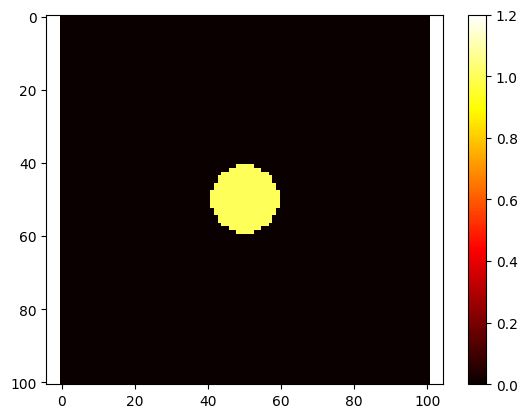

0.807382345199585


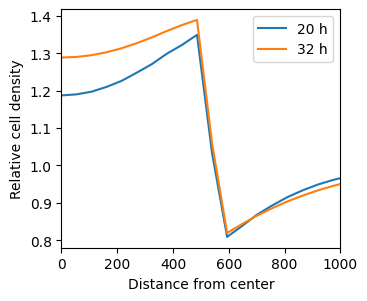

In [11]:
# Generating Figure 2G
import time

# PART 1: SIMULATE THE PATTERN
# This code simulates migration in response to the circular pattern from
# Figure 2E-G.

# 1.1 Make a uniform initial pattern of cells
ic = np.ones((101, 101))  # a 101 x 101 discretized grid of cells
#plt.imshow(ic)
#plt.show()

# 1.2 Construct an illumination circle centered at the origin
R = 9.35  # 500 um / 5400 um * 101 units = 9.35 unit diameter

x = np.arange(-50, 51)
y = np.arange(-50, 51)
xx, yy = np.meshgrid(x, y)

u = np.zeros_like(xx)
u[(xx**2 + yy**2) < R**2] = 1

plt.figure()
plt.imshow(u, cmap='hot', interpolation='nearest')
plt.axis('equal')
plt.clim(0, 1.2)
plt.colorbar()
plt.show()
pattern = u

# 1.3 Simulate this model
N = 101
L = 5400  # simulation width in um (6 mm = 6,000 um)
tF = 1920  # simulation time in min (32 h = 1,920 min)

f = construct_2D_model(N, L, pattern)

ic = ic.reshape(N**2)

tic2 = time.time()
solution = solve_ivp(f, [0, tF], ic) # if too long, reduce atol by factor of 10
toc2 = time.time()
print(toc2-tic2)

tv = np.linspace(0, tF, 100)
yv = interp1d(solution.t, solution.y)(tv)

# Save the simulation results
np.savez('Fig2G_simulation_results.npz', L=L, N=N, tF=tF, tv=tv, yv=yv)

# PART 2: PLOT RESULTS
# This code plots the simulation related to the experimental data of Figure 2G.
data = np.load('Fig2G_simulation_results.npz')
L = data['L']
N = data['N']
tF = data['tF']
tv = data['tv']
yv = data['yv']

# Generate spatial grid for plotting
xv = np.linspace(0, L, N)
X, Y = np.meshgrid(xv, xv)

# Get 20 hour data
i20 = np.argmax(tv >= 20*60)  # find the index for 20 hours
Z20 = yv[:, i20].reshape(N, N)

# Get 32 hour data
i32 = np.argmax(tv >= 32*60)  # find the index for 32 hours
Z32 = yv[:, i32].reshape(N, N)

# Plot the 20 and 32 hour data as in Fig. 2G
xx = X[50, 50:] - L/2  # get the x values for half of the data
plt.plot(xx, Z20[50, 50:], label='20 h')
plt.plot(xx, Z32[50, 50:], label='32 h')
plt.xlabel('Distance from center')
plt.ylabel('Relative cell density')
plt.legend(loc='best')
# plt.ylim([0, 10])
plt.xlim([0, 1000])
plt.gcf().set_size_inches(3.6, 3.1)  # match the figure size
plt.show()

To Do List:
- define get pattern function
- define construct 2d model function
- fig 6 code
- fig 2g code
